In [1]:
import collections
import numpy as np
import pandas as pd
import re
import glob
import json

%matplotlib inline
import matplotlib.pyplot as plt

from argparse import Namespace

from torchtext.utils import download_from_url, extract_archive

from wordcloud import WordCloud

from collections import Counter

Download the data from the [here](https://drive.google.com/uc?id=1k7GfVRqrHFK00ABkit0oGQo62fCakMSZ).   

Extract it to the folder called `.data`

In [2]:
args = Namespace(
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_processed_csv_prefix=".data/faq_with_splits_",
    seed=1234,
    min_questions_per_category=3000
)

In [3]:
def find_files(path):
    return glob.glob(path)

def read_json(filename):
    with open(filename, encoding='utf-8', errors='ignore') as json_file:
        data = json.load(json_file)
    return data

In [4]:
frames = []

for file in find_files('.data/gyakori_*'):
    print("Reading file:", file)
    frames.append(pd.DataFrame(read_json(file)))
    
faq = pd.concat(frames).reset_index(drop=True)

Reading file: .data\gyakori_allatok_14000
Reading file: .data\gyakori_egeszseg
Reading file: .data\gyakori_egeszseg_20000
Reading file: .data\gyakori_szamitastechnika
Reading file: .data\gyakori_szorakozas_30000


In [5]:
faq.head()

,rovid_kerdes,hosszu_kerdes,valasz,kategoriak,keywords
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,"[Állatok, Kutyák]","[kutya, őrkutya, aktív]"
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,"[Állatok, Egyéb kérdések]","[állatorvos, időpont]"
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...","[Állatok, Kutyák]","[husky, kutya, cica, összeszoktatás]"
3,Jár a kutyám feje jobbra balra és a szeme is m...,Jár a kutyám feje jobbra balra és a szeme is m...,Akkor a fenti youtube video es az alatta levo ...,"[Állatok, Kutyák]","[kutya, betegség, szem, állat, orvos]"
4,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,"[Állatok, Kutyák]","[vadászat, vizsla, kutya, állat, vad, lövés, p..."


In [6]:
faq.rename(columns = {
        "valasz": "answer",
        "kategoriak": "categories",
        "hosszu_kerdes": "long_question",
        "rovid_kerdes": "short_question"
    }, inplace = True)

In [7]:
faq['main_category'] = faq.apply(lambda row: row.categories[0], axis = 1)
faq['sub_category'] = faq.apply(lambda row: row.categories[1], axis = 1)

In [8]:
counter = Counter()
cs_faq = faq[faq.main_category == "Számítástechnika"]
_ = cs_faq.keywords.apply(lambda words: counter.update(words))

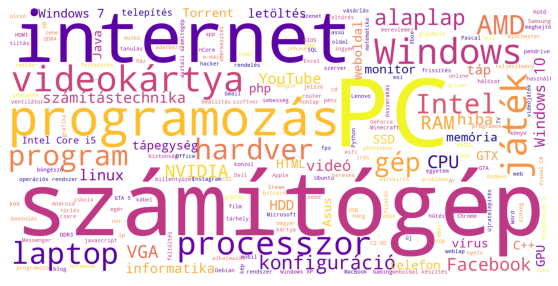

In [9]:
wordcloud = WordCloud(background_color="white", scale=5, colormap="plasma")
wordcloud.generate_from_frequencies(frequencies=counter)
plt.figure(figsize=(16, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [10]:
faq = faq.drop('keywords', axis = 1)
faq = faq.drop('categories', axis = 1)

In [11]:
faq.head()

,short_question,long_question,answer,main_category,sub_category
0,Nagy terület őrzésére milyen kutyát javasolnát...,Nagy terület őrzésére milyen kutyát javasolnát...,A komondor/kuvasz páros kimondottan ezekre a f...,Állatok,Kutyák
1,Az álllatorvosunkat alig lehet elérni. Ez szer...,Az álllatorvosunkat alig lehet elérni. Ez szer...,Keress másik orvost. Ennyi.,Állatok,Egyéb kérdések
2,Huskyval össze lehet szoktatni cicákat?,Huskyval össze lehet szoktatni cicákat? A cica...,"Persze, hogy össze lehet.A kutyának az első pi...",Állatok,Kutyák
3,Jár a kutyám feje jobbra balra és a szeme is m...,Jár a kutyám feje jobbra balra és a szeme is m...,Akkor a fenti youtube video es az alatta levo ...,Állatok,Kutyák
4,Vadászok! Vennék egy vizslát hobbi célra de el...,Vadászok! Vennék egy vizslát hobbi célra de el...,Normál esetben egy jó idegrendszerű kutyát nem...,Állatok,Kutyák


In [12]:
faq[faq.short_question.str.contains('\r')]

,short_question,long_question,answer,main_category,sub_category
153117,Tényleg ez történik a Star Wars-ban?\r\n\r\nSP...,Tényleg ez történik a Star Wars-ban?\r \r SPOI...,"Azert most mar jo ideje kint van a film, unnep...",Szórakozás,"Filmek, sorozatok"


In [13]:
def clear_escaped_characters(text):
    text = text.replace('\n', ' ')
    return text.replace('\r', ' ')

In [14]:
faq.long_question = faq.long_question.apply(lambda x: clear_escaped_characters(x))
faq.short_question = faq.short_question.apply(lambda x: clear_escaped_characters(x))
faq.answer = faq.answer.apply(lambda x: clear_escaped_characters(x))

In [15]:
faq = faq[~faq.long_question.str.contains('\[link\]') & ~faq.answer.str.contains('\[link\]')]

In [16]:
categories = set(faq.main_category)
print(categories)

{'Egészség', 'Gyerekvállalás, nevelés', 'Szórakozás', 'Állatok', 'Számítástechnika'}


In [17]:
def number_of_questions_by_category():
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle('Number of questions per categories')

    grouped_faq = faq.groupby(faq.main_category)
    data_to_plot = grouped_faq.size().sort_values()

    data_to_plot.plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
    data_to_plot.plot(kind='bar', ax=ax[1])

    y_axis_0 = ax[0].axes.get_yaxis()
    y_axis_0.set_visible(False)

    ax[1].set_xlabel("")
    ax[1].bar_label(ax[1].containers[0])
    
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(0)

    plt.show()

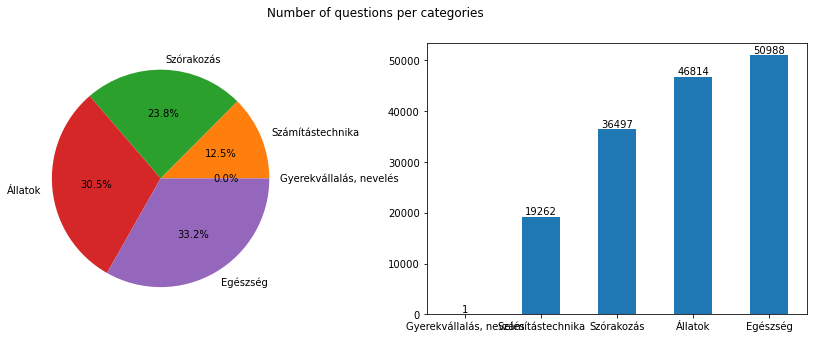

In [18]:
number_of_questions_by_category()

In [19]:
for category in categories:
    category_size = faq[faq.main_category == category].shape[0]
    if category_size < args.min_questions_per_category:
        faq = faq[faq.main_category != category]

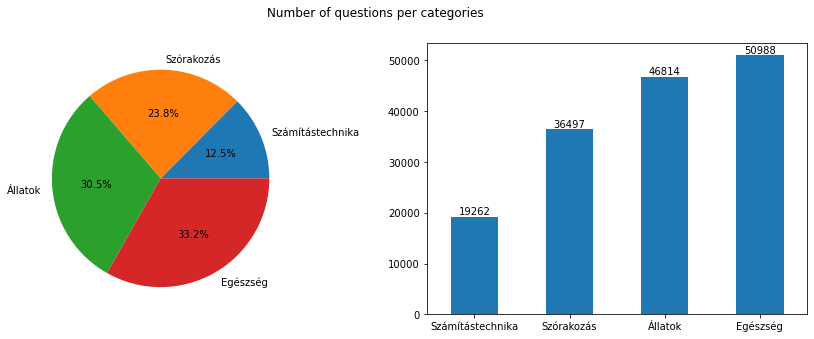

In [20]:
number_of_questions_by_category()

In [21]:
faq = faq.reset_index(drop=True)

In [22]:
def add_splits(df):
    categories = set(df.main_category)

    for category in categories:
        df_ctg = df[df.main_category == category]
        df_ctg = df_ctg.sample(frac=1)
        
        n = df_ctg.shape[0]
        n_train = int(args.train_proportion * n)
        n_val = int(args.val_proportion * n)
        n_test = int(args.test_proportion * n)

        df.loc[df_ctg[:n_train].index.values, 'split'] = 'train'
        df.loc[df_ctg[n_train:n_train+n_val].index.values, 'split'] = 'val'
        df.loc[df_ctg[n_train+n_val:].index.values, 'split'] = 'test'
                
    return df

In [23]:
faq_with_splits = add_splits(faq)

In [25]:
faq_with_splits = faq_with_splits.sample(frac=1)

In [26]:
faq_with_splits.head()

,short_question,long_question,answer,main_category,sub_category,split
60953,"Hogy tudom a hamis bevésődéseket, rossz gondol...","Hogy tudom a hamis bevésődéseket, rossz gondol...","Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Milyen balhé volt Dancsó Péter és Fankadeli kö...,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,Hol vannak leírva a Semmiképp sem Dominion sza...,Hol vannak leírva a Semmiképp sem Dominion sza...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,A legjobb fogorvos Magyarországon?,"A legjobb fogorvos Magyarországon? Szóval, tud...","Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,A hörcsögök egész szeme fekete vagy csak egy r...,A hörcsögök egész szeme fekete vagy csak egy r...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


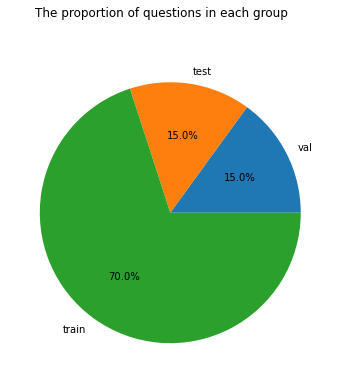

In [27]:
fig, ax = plt.subplots(1, figsize=(10, 6))

fig.suptitle('The proportion of questions in each group')
data_to_plot = faq_with_splits.groupby(faq_with_splits.split).size().sort_values()

data_to_plot.plot(kind='pie', ax=ax, autopct='%1.1f%%')

y_axis_0 = ax.axes.get_yaxis()
y_axis_0.set_visible(False)

plt.show()

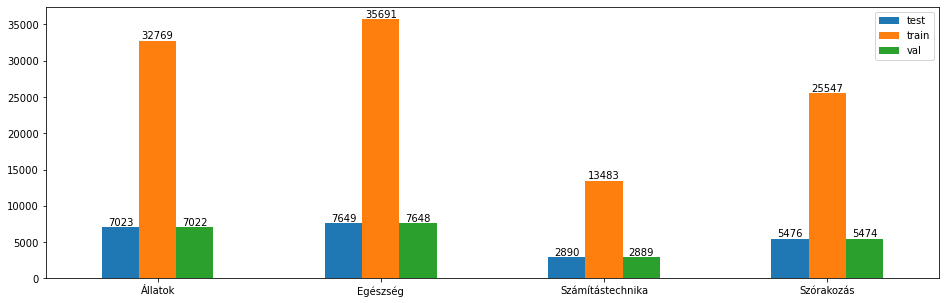

In [28]:
fig, ax = plt.subplots(1, figsize=(16, 5))

splits = list(set(faq_with_splits.split))

index = set(faq_with_splits.main_category)
questions_in = {}

for split in splits:
    questions_in[split] = []
    faq_split = faq_with_splits[faq_with_splits.split == split]
    
    for category in index:
        questions_in[split].append(faq_split[faq_split.main_category == category].shape[0])

df = pd.DataFrame({split: questions_in[split] for split in splits}, index=index)        
df.head()

df.plot(kind='bar',ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)

plt.show()

### Lemmatization, stemming, stop-word filtering

Install [Hungarian spaCy modell](https://github.com/huspacy/huspacy)
```
pip install https://github.com/huspacy/huspacy/releases/download/hu_core_ud_lg-0.3.1/hu_core_ud_lg-0.3.1-py3-none-any.whl
```

In [31]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import HungarianStemmer
from nltk.corpus import stopwords

import nltk

import hu_core_ud_lg

In [30]:
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('hungarian'))

In [32]:
tokenizer = RegexpTokenizer(r'\w+')

stemmer = HungarianStemmer()

question = faq_with_splits.iloc[2]['long_question']

# Tokenization
tokenized_sentence = tokenizer.tokenize(question)

# Stopword filtering
filtered_sentence = [w for w in tokenized_sentence if not w in stop_words]

# Lemmatization
lemmatizer = hu_core_ud_lg.load()

lemmatizer.remove_pipe('parser')
lemmatizer.remove_pipe('ner')
lemmatizer.add_pipe(lemmatizer.create_pipe('sentencizer'))

doc = lemmatizer(" ".join(filtered_sentence))

In [33]:
print(f"Original question:\n{question}\n")

print("After tokenization:")
for w in tokenized_sentence:
    print(w, end=" ")

print("\n\nAfter stopword filtering:")
for w in filtered_sentence:
    print(w, end=" ")

print("\n\nAfter lemmatization:")
for w in doc:
    print(w.lemma_.lower(), end=" ")
    
print("\n\nAfter stemming:")
for w in tokenized_sentence:
    print(stemmer.stem(w), end=" ")

Original question:
Hol vannak leírva a Semmiképp sem Dominion szabályai LoLban? Nem találom az oldalon,hogy hogy vannak ebben a módban a pontozások,stb. Tudom hogy már vége ennek a módnak de felidegesít,hogy úgy játszottam,hogy nem is értettem mi történik közben.

After tokenization:
Hol vannak leírva a Semmiképp sem Dominion szabályai LoLban Nem találom az oldalon hogy hogy vannak ebben a módban a pontozások stb Tudom hogy már vége ennek a módnak de felidegesít hogy úgy játszottam hogy nem is értettem mi történik közben 

After stopword filtering:
Hol leírva Semmiképp Dominion szabályai LoLban Nem találom oldalon módban pontozások stb Tudom vége módnak felidegesít játszottam is értettem történik közben 

After lemmatization:
hol leírva semmiképp dominion szabály lol nem talál oldal mód pontozás stb tud vég mód felidegesí játszik is ért történik közben 

After stemming:
hol van leírv a semm sem domin szabály lol nem talál az oldal hogy hogy van eb a mó a pontozás stb tud hogy már vég e

In [46]:
import time

In [47]:
def tokenize_question(question):
    tokenized = tokenizer.tokenize(question)
    return " ".join(tokenized)

In [48]:
def lemmatize_question(question):
    doc = lemmatizer(question)
    lemmatized = [w.lemma_.lower() for w in doc]
    return " ".join(lemmatized)

In [49]:
def stem_question(question):
    stemmed = [stemmer.stem(w) for w in question.split()]
    return " ".join(stemmed)

In [50]:
def filter_question(question):
    tokenized_question = " ".join(tokenizer.tokenize(question))
    filtered = [w for w in tokenized_question.split() if not w in stop_words]

    return " ".join(filtered)

In [51]:
def create_dataset(original_df, func, name):
    result = original_df.copy()

    start_time = int(time.time() * 1000)
       
    result.short_question = original_df.short_question.apply(func)
    result.long_question = original_df.long_question.apply(func)
    
    end_time = int(time.time() * 1000)
    print(f"Creating dataset called '{name}' took: {(end_time - start_time) / 1000.0} seconds")
    
    return result

In [52]:
def create_datasets(df):
    result = {}
    
    result['tokenized'] = create_dataset(df, tokenize_question, "tokenized")
    
    result['stemmed'] = create_dataset(df, stem_question, "stemmed")
    result['lemmatized'] = create_dataset(df, lemmatize_question, "lemmatized")
    
    result['filtered'] = create_dataset(df, filter_question, "filtered")
    
    result['stemmed_filtered'] = create_dataset(result['filtered'], stem_question, "stemmed_filtered")
    result['lemmatized_filtered'] = create_dataset(result['filtered'], lemmatize_question, "lemmatized_filtered")
    
    return result

In [53]:
dataframes = create_datasets(faq_with_splits)

Creating dataset called 'tokenized' took: 4.541 seconds
Creating dataset called 'stemmed' took: 282.583 seconds
Creating dataset called 'lemmatized' took: 1867.602 seconds
Creating dataset called 'filtered' took: 7.978 seconds
Creating dataset called 'stemmed_filtered' took: 183.095 seconds
Creating dataset called 'lemmatized_filtered' took: 1525.156 seconds


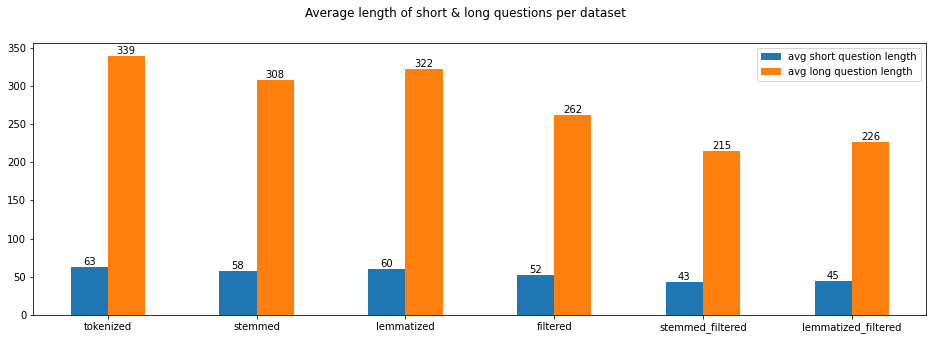

In [58]:
fig, ax = plt.subplots(1, figsize=(16, 5))
fig.suptitle('Average length of short & long questions per dataset')

index = dataframes.keys()
short_len = []
long_len = []
for key in index:
    long_len.append(round(dataframes[key].long_question.str.len().mean()))
    short_len.append(round(dataframes[key].short_question.str.len().mean()))

df = pd.DataFrame({'avg short question length': short_len, 'avg long question length': long_len}, index=index)        

df.plot(kind='bar', ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for label in ax.containers:
    ax.bar_label(label)

plt.show()

In [59]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,Hogy tudom hamis bevésődéseket rossz gondolato...,Hogy tudom hamis bevésődéseket rossz gondolato...,"Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,Milyen balhé Dancsó Péter Fankadeli,Milyen balhé Dancsó Péter Fankadeli,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,Hol leírva Semmiképp Dominion szabályai LoLban,Hol leírva Semmiképp Dominion szabályai LoLban...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,A legjobb fogorvos Magyarországon,A legjobb fogorvos Magyarországon Szóval tudni...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,A hörcsögök szeme fekete része,A hörcsögök szeme fekete része Aki tudja válas...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [60]:
dataframes['stemmed'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,"hogy tud a hamis bevésődéseket, rossz gondolat...","hogy tud a hamis bevésődéseket, rossz gondolat...","Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,mily balh vol dancsó péter és fankadel között?,mily balh vol dancsó péter és fankadel között?,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,hol van leírv a semm sem domin szabály lolban?,hol van leírv a semm sem domin szabály lolban?...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,a legjobb fogorvos magyarországon?,"a legjobb fogorvos magyarországon? szóval, tud...","Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,a hörcsög egész szem feket vagy csak egy része?,a hörcsög egész szem feket vagy csak egy része...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [61]:
dataframes['lemmatized'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,"hogy tud a hamis bevésődés , rossz gondolat fe...","hogy tud a hamis bevésődés , rossz gondolat fe...","Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,milyen balhé volt dancsó péter és fankadeli kö...,milyen balhé volt dancsó péter és fankadeli kö...,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,hol van leírva a semmiképp sem dominion szabál...,hol van leírva a semmiképp sem dominion szabál...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,a jó fogorvos magyarország ?,"a jó fogorvos magyarország ? szóval , tud kell...","Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,a hörcsög egész szem fekete vagy csak egy rész ?,a hörcsög egész szem fekete vagy csak egy rész...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [62]:
dataframes['filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,Hogy tudom hamis bevésődéseket rossz gondolato...,Hogy tudom hamis bevésődéseket rossz gondolato...,"Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,Milyen balhé Dancsó Péter Fankadeli,Milyen balhé Dancsó Péter Fankadeli,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,Hol leírva Semmiképp Dominion szabályai LoLban,Hol leírva Semmiképp Dominion szabályai LoLban...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,A legjobb fogorvos Magyarországon,A legjobb fogorvos Magyarországon Szóval tudni...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,A hörcsögök szeme fekete része,A hörcsögök szeme fekete része Aki tudja válas...,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [63]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,hogy tud hamis bevésődés rossz gondolat felülírn,hogy tud hamis bevésődés rossz gondolat felülí...,"Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,mily balh dancsó péter fankadel,mily balh dancsó péter fankadel,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,hol leírv semm domin szabály lol,hol leírv semm domin szabály lol nem talál old...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,a legjobb fogorvos magyarország,a legjobb fogorvos magyarország szó tudn ról e...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,a hörcsög szem feket rész,a hörcsög szem feket rész ak tud válaszolj,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [64]:
dataframes['lemmatized_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,hogy tud hamis bevésődés rossz gondolat felülír,hogy tud hamis bevésődés rossz gondolat felülí...,"Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,mily balhé dancsó péter fankadeli,mily balhé dancsó péter fankadeli,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,hol leírva semmiképp dominion szabály lol,hol leírva semmiképp dominion szabály lol nem ...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,a jó fogorvos magyarország,a jó fogorvos magyarország szo tud róla elképe...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,a hörcsög szem fekete rész,a hörcsög szem fekete rész aki tud válaszol,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [65]:
dataframes['stemmed_filtered'].head()

,short_question,long_question,answer,main_category,sub_category,split
60953,hogy tud hamis bevésődés rossz gondolat felülírn,hogy tud hamis bevésődés rossz gondolat felülí...,"Korlátozó hiedelmeknek hívják őket, de tudom, ...",Egészség,Mentális egészség,val
137918,mily balh dancsó péter fankadel,mily balh dancsó péter fankadel,Röviden: Dancsó lehúzta Fankadeli egyik haverj...,Szórakozás,"Sztárok, bulvár",train
130972,hol leírv semm domin szabály lol,hol leírv semm domin szabály lol nem talál old...,"A pontozás pont olyan, mint a dominionnál volt...",Szórakozás,Játékok,train
61013,a legjobb fogorvos magyarország,a legjobb fogorvos magyarország szó tudn ról e...,"Nincs olyan, hogy legjobb, a fogorvosok ugyanú...",Egészség,"Fogak, szájápolás",train
19580,a hörcsög szem feket rész,a hörcsög szem feket rész ak tud válaszolj,"Amúgy tényleg, szinte minden nap kiír valami f...",Állatok,Kisemlősök,train


In [66]:
for dataframe_key in dataframes:
    filename = f"{args.output_processed_csv_prefix}{dataframe_key}.csv"
    print(f"Creating {filename}")
    dataframes[dataframe_key].to_csv(filename, index=False, encoding='utf-8', errors='ignore')

Creating .data/faq_with_splits_tokenized.csv
Creating .data/faq_with_splits_stemmed.csv
Creating .data/faq_with_splits_lemmatized.csv
Creating .data/faq_with_splits_filtered.csv
Creating .data/faq_with_splits_stemmed_filtered.csv
Creating .data/faq_with_splits_lemmatized_filtered.csv
